# 1. Introduction

## Problem Statement

Aircraft accidents, though relatively rare, often results in catastrophic consequences. This consequences involved in significant loss of life and financial costs. This could be prevented if aviation industry can predict their potential accident by understanding the contributong factors and circumstances leading to these accidents, this could enhancing aviation safety and reducing the likelihood of future incidents.

For this, we will develop a machine learning model to predict whether an aircraft risk of accident fall into category. This could help to prevent missed airplane handling and maintenance which will caused sever accident.

# 2. Import Libraries

In [145]:
import pandas as pd
import numpy as np
import pickle
import us

from scipy.stats import chi2_contingency, f_oneway

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.metrics import recall_score, classification_report, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


# 3. Data Loading

In [146]:
# load the original data
csv_df = pd.read_csv('Airplane Accident.csv')

In [147]:
# use features that will be used for prediction
df = csv_df[['City','State','Country','HasSafetyRec','Latitude','Longitude','Make','Model','NumberOfEngines','WeatherCondition','FAR','EventType']]

In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9613 entries, 0 to 9612
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   City              9613 non-null   object 
 1   State             7330 non-null   object 
 2   Country           9613 non-null   object 
 3   HasSafetyRec      9613 non-null   bool   
 4   Latitude          9613 non-null   float64
 5   Longitude         9613 non-null   float64
 6   Make              9613 non-null   object 
 7   Model             9613 non-null   object 
 8   NumberOfEngines   7749 non-null   object 
 9   WeatherCondition  7230 non-null   object 
 10  FAR               9572 non-null   object 
 11  EventType         9613 non-null   object 
dtypes: bool(1), float64(2), object(9)
memory usage: 835.6+ KB


# 3.5. Manual Data Enrichment

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9613 entries, 0 to 9612
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   City              9613 non-null   object 
 1   State             7330 non-null   object 
 2   Country           9613 non-null   object 
 3   HasSafetyRec      9613 non-null   bool   
 4   Latitude          9613 non-null   float64
 5   Longitude         9613 non-null   float64
 6   Make              9613 non-null   object 
 7   Model             9613 non-null   object 
 8   NumberOfEngines   7749 non-null   object 
 9   WeatherCondition  7230 non-null   object 
 10  FAR               9572 non-null   object 
 11  EventType         9613 non-null   object 
dtypes: bool(1), float64(2), object(9)
memory usage: 835.6+ KB


In [150]:
df['Country'].value_counts()

Country
United States             7335
Brazil                     179
United Kingdom             151
Australia                  139
Mexico                     127
                          ... 
Ghana                        1
Paracel Islands              1
Bosnia And Herzegovina       1
Armenia                      1
Nicaragua                    1
Name: count, Length: 151, dtype: int64

In [151]:
df['State'].value_counts()

State
Texas             652
California        628
Florida           569
Alaska            498
Arizona           264
Georgia           234
Colorado          228
Washington        206
North Carolina    196
Idaho             187
Oregon            178
Utah              162
New York          153
Tennessee         149
Illinois          143
Pennsylvania      142
Ohio              141
Minnesota         136
Michigan          133
Wisconsin         130
Nevada            129
Virginia          129
Louisiana         125
Missouri          124
Oklahoma          114
Indiana           114
Arkansas          107
South Carolina    106
Montana            99
Alabama            98
New Mexico         98
Kansas             94
New Jersey         76
Iowa               75
Kentucky           72
Nebraska           72
Maryland           70
Wyoming            60
Mississippi        56
Hawaii             53
Massachusetts      51
Maine              40
South Dakota       38
North Dakota       38
Connecticut        35
New 

## Handling Missing Values

In [152]:
df.isna().sum()

City                   0
State               2283
Country                0
HasSafetyRec           0
Latitude               0
Longitude              0
Make                   0
Model                  0
NumberOfEngines     1864
WeatherCondition    2383
FAR                   41
EventType              0
dtype: int64

There are many missing values in this dataset. I decide to handle this now rather than after splitting, since it is a categorical data and we need to compare it to other column.

### Missing Values for State

Logically speaking and based on real-life understanding, countries that using state usually used by United States. Most of other state use province or alike. The evidence is most of the state value_counts are from united states.

In [153]:
df['State'].value_counts()

State
Texas             652
California        628
Florida           569
Alaska            498
Arizona           264
Georgia           234
Colorado          228
Washington        206
North Carolina    196
Idaho             187
Oregon            178
Utah              162
New York          153
Tennessee         149
Illinois          143
Pennsylvania      142
Ohio              141
Minnesota         136
Michigan          133
Wisconsin         130
Nevada            129
Virginia          129
Louisiana         125
Missouri          124
Oklahoma          114
Indiana           114
Arkansas          107
South Carolina    106
Montana            99
Alabama            98
New Mexico         98
Kansas             94
New Jersey         76
Iowa               75
Kentucky           72
Nebraska           72
Maryland           70
Wyoming            60
Mississippi        56
Hawaii             53
Massachusetts      51
Maine              40
South Dakota       38
North Dakota       38
Connecticut        35
New 

In [154]:
# if state missing values and country is united states
df[(df['State'].isna()) & (df['Country'] == 'United States')]

,City,State,Country,HasSafetyRec,Latitude,Longitude,Make,Model,NumberOfEngines,WeatherCondition,FAR,EventType
7510,GULF OF MEXICO,NaN,United States,False,26.014999,-82.112503,JABIRU,J250-SP,1,VMC,091,ACC
8390,Gulf of Mexico,NaN,United States,False,28.866945,-89.302223,Piper,PA46,1,VMC,091,ACC
8409,Charlotte Amalie,NaN,United States,False,18.337499,-64.967224,Piper,PA23,2,VMC,091,ACC
8801,Saipan,NaN,United States,False,15.123888,145.731384,Piper,PA28,1,VMC,091,ACC
9268,Saipan,NaN,United States,False,15.118055,145.724166,Piper,PA32,1,VMC,135,ACC


Seeing this we see that some don't have the same format, GULF OF MEXICO and Gulf of Mexico, we need to clean something like this first.

In [155]:
# rename the gulf of Mexico to only one format
df.loc[:, 'City'] = df['City'].str.lower().str.title().str.replace(r'\bOf\b', 'of', regex=True)

In [156]:
df[(df['State'].isna()) & (df['Country'] == 'United States')]

,City,State,Country,HasSafetyRec,Latitude,Longitude,Make,Model,NumberOfEngines,WeatherCondition,FAR,EventType
7510,Gulf of Mexico,NaN,United States,False,26.014999,-82.112503,JABIRU,J250-SP,1,VMC,091,ACC
8390,Gulf of Mexico,NaN,United States,False,28.866945,-89.302223,Piper,PA46,1,VMC,091,ACC
8409,Charlotte Amalie,NaN,United States,False,18.337499,-64.967224,Piper,PA23,2,VMC,091,ACC
8801,Saipan,NaN,United States,False,15.123888,145.731384,Piper,PA28,1,VMC,091,ACC
9268,Saipan,NaN,United States,False,15.118055,145.724166,Piper,PA32,1,VMC,135,ACC


Now to fill the missing values based on real-life data.

In [157]:
# replace the missing values
df.loc[(df['City'] == 'Gulf of Mexico'), 'State'] = 'Mexico'
df.loc[(df['City'] == 'Charlotte Amalie'), 'State'] = 'Virgin Islands'
df.loc[(df['City'] == 'Saipan'), 'State'] = 'Northern Mariana Islands'

In [158]:
df[(df['State'].isna()) & (df['Country'] != 'United States')]

,City,State,Country,HasSafetyRec,Latitude,Longitude,Make,Model,NumberOfEngines,WeatherCondition,FAR,EventType
3,Oslo,NaN,Norway,False,0.000000,0.000000,BOEING,737,NaN,NaN,NaN,ACC
15,Gramado,NaN,Brazil,False,-29.367222,-50.860000,PIPER,PA42,2,NaN,NUSN,ACC
18,Émerainville,NaN,France,False,0.000000,0.000000,PIPER,PA28,NaN,NaN,NUSN,ACC
29,Molde,NaN,Norway,False,62.745546,7.267263,BOEING,737,2,NaN,NUSC,INC
32,Crawley,NaN,United Kingdom,False,51.149218,-0.192406,BOEING,737,2,NaN,NUSC,INC
...,...,...,...,...,...,...,...,...,...,...,...,...
9598,Lanseria,NaN,South Africa,False,-25.943889,27.921667,Cirrus,SR22,NaN,NaN,NUSN,ACC
9599,Tooradin,NaN,Australia,False,-38.215557,145.423614,Cessna,182,1,NaN,NUSN,ACC
9606,Chennai,NaN,India,False,0.000000,0.000000,AIRBUS,A320,2,NaN,NUSC,INC
9607,Lagos,NaN,Nigeria,False,0.000000,0.000000,BOEING,737,NaN,NaN,NUSC,INC


As for the rest of state country, we will fill it same as their country.

In [159]:
# a for loop to replace state with the same values as country
for country in df['Country'].unique():
    # check the country same as loop in country unique values and state is missing, change the state the same as country
    df.loc[(df['Country'] == country) & (df['State'].isna()), 'State'] = country


In [160]:
# check missing values
df.isna().sum()

City                   0
State                  0
Country                0
HasSafetyRec           0
Latitude               0
Longitude              0
Make                   0
Model                  0
NumberOfEngines     1864
WeatherCondition    2383
FAR                   41
EventType              0
dtype: int64

### Missing Values of Number of Engine

Since the number of engines are really tied to their manufacture and model, I will fill it based on data I can get.

### BOEING Airplane

First I want to check the BOEING Airplane.

In [161]:
df[(df['NumberOfEngines'].isna()) & (df['Make'] == 'BOEING')][['Make','Model','NumberOfEngines']]

,Make,Model,NumberOfEngines
3,BOEING,737,NaN
49,BOEING,737,NaN
56,BOEING,767,NaN
67,BOEING,MD 10-30F,NaN
72,BOEING,787-9,NaN
...,...,...,...
9508,BOEING,737,NaN
9521,BOEING,787,NaN
9535,BOEING,737,NaN
9565,BOEING,737,NaN


Then check their unique model.

In [162]:
df[(df['Make'] == 'BOEING') & (df['NumberOfEngines'].isna())]['Model'].unique()

array(['737', '767', 'MD 10-30F', '787-9', '737-700', '777-223',
       '757-231', '787', '727', '747', '737-9', '777', '767-300', 'B777',
       '737-8', '777-3FX (ER)', '747-400', '737 Max 8-200', '737-800',
       '717', '777-319ER', '787-900', 'MD82', '757', '2X6C', '737-8EH',
       '737-4B6', '787-800', 'CV2', '737-8H4'], dtype=object)

Reference:<br>
 - [Boeing website](https://www.boeing.com/commercial/)
 - [Wikipedia](https://en.wikipedia.org/wiki/List_of_Boeing_aircraft)

| Model | Number of Engines | Notes                                      |
|-------|-------------------|--------------------------------------------|
| 717   | 2                 | Twin-engine, regional jet                 |
| 727   | 3                 | Tri-engine, narrow-body jet               |
| 737   | 2                 | Twin-engine, narrow-body jet              |
| 747   | 4                 | Four-engine, wide-body jumbo jet          |
| 757   | 2                 | Twin-engine, narrow-body jet              |
| 767   | 2                 | Twin-engine, wide-body jet                |
| 777   | 2                 | Twin-engine, wide-body jet                |
| 787   | 2                 | Twin-engine, wide-body Dreamliner         |


In [163]:
# a dictionary to make the fill easier
BoeingEngine = {
    '717': 2,
    '727': 3,
    '737': 2,
    '747': 4,
    '757': 2,
    '767': 2,
    '777': 2,
    '787': 2,
}

# for loop to check each index
for i in df.index:
    # if the said index is NaN and the model of the index is BOEING
    if pd.isna(df['NumberOfEngines'][i]) and df['Make'][i] == 'BOEING':
        # put the model name in model variables
        model = str(df['Model'][i])
        # check the keys in BoeingEngine dictionary
        for key in BoeingEngine.keys():
            # chek if key from BoeingEngine is inside mode of the index
            if key in model:
                # put the values in specific index and column number of engine, with BoeingEngine dictionary values
                df.at[i, 'NumberOfEngines'] = BoeingEngine[key]
                # break so the loop can stop
                break

In [164]:
df[(df['NumberOfEngines'].isna()) & (df['Make'] == 'BOEING')][['Make','Model','NumberOfEngines']]

,Make,Model,NumberOfEngines
67,BOEING,MD 10-30F,NaN
4545,BOEING,MD82,NaN
4849,BOEING,2X6C,NaN
8928,BOEING,CV2,NaN


| Make   | Model | Number of Engines | Reference Link                                                                 |
|--------|-------|-------------------|-------------------------------------------------------------------------------|
| BOEING | B777  |2| [Boeing 777](https://en.wikipedia.org/wiki/Boeing_777)                       |
| BOEING | 2X6C  |2| [737 - 2X6C](https://asn.flightsafety.org/wikibase/365686) |
| BOEING | CV2   |12| [Cargo Vessel](https://en.wikipedia.org/wiki/Boeing_Cargo_Air_Vehicle)|
| BOEING | MD 10-30F|3|[MD-10](https://en.wikipedia.org/wiki/McDonnell_Douglas_DC-10#MD-10) |
| BOEING | MD82|2|[MD-82](https://en.wikipedia.org/wiki/McDonnell_Douglas_MD-80#Variants)|



In [165]:
# as for the rest, just manually fill it based on the internet
df.loc[(df['Make'] == 'BOEING') & (df['Model'] == 'B777'), 'NumberOfEngines'] = 2
df.loc[(df['Make'] == 'BOEING') & (df['Model'] == '2X6C'), 'NumberOfEngines'] = 2
df.loc[(df['Make'] == 'BOEING') & (df['Model'] == 'CV2'), 'NumberOfEngines'] = 12
df.loc[(df['Make'] == 'BOEING') & (df['Model'] == 'MD 10-30F'), 'NumberOfEngines'] = 3
df.loc[(df['Make'] == 'BOEING') & (df['Model'] == 'MD82'), 'NumberOfEngines'] = 2

In [166]:
df[(df['NumberOfEngines'].isna()) & (df['Make'] == 'BOEING')][['Make','Model','NumberOfEngines']]

,Make,Model,NumberOfEngines


### AIRBUS Airplane

Reference links:<br>
 - [Airbus website](https://www.airbus.com/en)
 - [Wikipedia](https://en.wikipedia.org/wiki/List_of_Airbus_aircraft)

| Model         | Number of Engines | Notes                                       |
|---------------|-------------------|---------------------------------------------|
| 220          | 2                 | Twin-engine, narrow-body jet                |
| 300          | 2                 | Twin-engine, wide-body jet                  |
| 300 F4-622R  | 2                 | Twin-engine freighter version of A300       |
| 320          | 2                 | Twin-engine, narrow-body jet                |
| 321          | 2                 | Twin-engine, narrow-body jet                |
| 330          | 2                 | Twin-engine, wide-body jet                  |
| 350          | 2                 | Twin-engine, wide-body jet                  |
| 380          | 4                 | Four-engine, double-deck wide-body jet      |
| 350         | 1                 | Single-engine helicopter                    |

In [167]:
# this code basically same as Boeing only change some things instead of BOEING, its AIRBUS
AirbusEngine = {
    '220': 2,
    '300': 2,
    '300 F4-622R': 2,
    '320': 2,
    '321': 2,
    '330': 2,
    '350': 2,
    '380': 4,
    '350': 1,
    '332': 2,
    '319': 2
}

for i in df.index:
    if pd.isna(df['NumberOfEngines'][i]) and df['Make'][i] == 'AIRBUS':
        model = df['Model'][i]
        for key in AirbusEngine.keys():
            if key in model:
                df.loc[i, 'NumberOfEngines'] = AirbusEngine[key]
                break

In [168]:
df[(df['NumberOfEngines'].isna()) & (df['Make'] == 'AIRBUS')][['Make','Model','NumberOfEngines']]

,Make,Model,NumberOfEngines


### CESSNA Missing Values

In [169]:
df[(df['NumberOfEngines'].isna())][['Make','Model','NumberOfEngines']]

,Make,Model,NumberOfEngines
0,CESSNA,172N,NaN
2,CESSNA,310D,NaN
5,DIAMOND AIRCRAFT IND INC,DA 40 NG,NaN
7,CESSNA,T210L,NaN
8,BEECH,58,NaN
...,...,...,...
9568,MCDONNELL DOUGLAS,MD11,NaN
9569,Hill Group LLC,CCX-2000,NaN
9573,Champion,7ECA,NaN
9592,Piper,PA28R,NaN


[CESSNA Model Engine Reference](https://en.wikipedia.org/wiki/List_of_Cessna_models)

| Model       | Number of Engines | Notes                                           |
|-------------|-------------------|-------------------------------------------------|
| 150 Series  | 1                 | Popular for training and personal aviation      |
| 172 Series  | 1                 | The most produced airplane in history           |
| 182 Series  | 1                 | Known for high performance and range            |
| 185 Series  | 1                 | Utility aircraft, often used for bush flying    |
| 206 Series  | 1                 | Utility aircraft, frequently used in remote areas|
| 210 Series  | 1                 | Pressurized cabin option available (P210 model) |
| 310 Series  | 2                 | First twin-engine model produced by Cessna      |
| 336/337     | 2                 | Push-pull configuration with centerline thrust  |
| 340 Series  | 2                 | Pressurized cabin for business aviation         |
| 401/402     | 2                 | Used for passenger and cargo transport          |
| 414 Series  | 2                 | Pressurized cabin with enhanced comfort         |
| 421 Series  | 2                 | Golden Eagle series, luxury business aircraft   |
| 425 Series  | 2                 | Conquest I, twin turboprop aircraft             |
| 441 Series  | 2                 | Conquest II, twin turboprop for business travel |
| 500/510/525 | 2                 | CitationJet series, business jets               |
| 550/560     | 2                 | Citation series, mid-size business jets         |
| 680 Series  | 2                 | Sovereign, long-range business jet              |
| 750 Series  | 2                 | Citation X, high-speed business jet             |
| 208 Series  | 1                 | Caravan, utility aircraft for cargo/passengers  |
| 425 Series  | 2                 | Conquest, turboprop for light business aviation |


In [170]:
df[(df['Make'] == 'CESSNA')][['Make','Model','NumberOfEngines']]

,Make,Model,NumberOfEngines
0,CESSNA,172N,NaN
2,CESSNA,310D,NaN
7,CESSNA,T210L,NaN
12,CESSNA,182B,1
22,CESSNA,172,NaN
...,...,...,...
9460,CESSNA,172,1
9470,CESSNA,U206,NaN
9498,CESSNA,U206G,NaN
9503,CESSNA,150,1


In [171]:
# in my understanding, CESSNA model usually coded same as their engines
# first I extract the number in their model (e.g 310D -> get 310) and turn it to float dtype
df.loc[:, 'ModelNumber'] = df['Model'].str.extract(r'(\d+)').astype(float)

# then based on the new column model number give engine, usually CESSNA will code their model below 300 have 1 engine
# and above 300 have 2 engines. CESSNA to my understanding still have no 4 or above engine
df.loc[(df['Make'] == 'CESSNA') & (df['ModelNumber'] < 300), 'NumberOfEngines'] = 1
df.loc[(df['Make'] == 'CESSNA') & (df['ModelNumber'] >= 300), 'NumberOfEngines'] = 2

C:\Users\Affan\AppData\Local\Temp\ipykernel_8072\645774199.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'ModelNumber'] = df['Model'].str.extract(r'(\d+)').astype(float)


In [172]:
# then I drop the unused ModelNumber
df = df.drop(['ModelNumber'], axis=1)

In [173]:
df[(df['Make'] == 'CESSNA')][['Make','Model','NumberOfEngines']]

,Make,Model,NumberOfEngines
0,CESSNA,172N,1
2,CESSNA,310D,2
7,CESSNA,T210L,1
12,CESSNA,182B,1
22,CESSNA,172,1
...,...,...,...
9460,CESSNA,172,1
9470,CESSNA,U206,1
9498,CESSNA,U206G,1
9503,CESSNA,150,1


### Missing Values for Other Manufacture

As for the others, since it is too much to search we will fill it based on the airplane model instead. Based on my understanding the Airplane model of non-big company usually share the same code that will indicates their engine number.

In [174]:
df[(df['NumberOfEngines'].isna())][['Make','Model','NumberOfEngines']]

,Make,Model,NumberOfEngines
5,DIAMOND AIRCRAFT IND INC,DA 40 NG,NaN
8,BEECH,58,NaN
13,BURSEY FREDERICK J,RV-7A,NaN
16,Uvify,IFO,NaN
18,PIPER,PA28,NaN
...,...,...,...
9568,MCDONNELL DOUGLAS,MD11,NaN
9569,Hill Group LLC,CCX-2000,NaN
9573,Champion,7ECA,NaN
9592,Piper,PA28R,NaN


In [175]:
# using the same logic as CESSNA
df['ModelNumber'] = df['Model'].str.extract(r'(\d+)').astype(float)
df.loc[df['ModelNumber'] < 300, 'NumberOfEngines'] = 1
df.loc[df['ModelNumber'] >= 300, 'NumberOfEngines'] = 2

df = df.drop(['ModelNumber'], axis=1)

Now there are only several missing values we need to fill.

In [176]:
df[(df['NumberOfEngines'].isna())][['Make','Model','NumberOfEngines']]

,Make,Model,NumberOfEngines
16,Uvify,IFO,NaN
41,CHRISTEN,EAGLE II,NaN
506,WAG AERO,Sport Trainer,NaN
573,BRM AERO SRO,BRISTELL S-LSA,NaN
665,Just,HIGHLANDER,NaN
...,...,...,...
9116,Flight Design,CTSW,NaN
9159,Cub Crafters,CARBON CUB EX,NaN
9247,ACRO,SUPER ACRO SPORT I,NaN
9248,TL Ultralight SRO,STINGSPORT,NaN


In [177]:
df[(df['Make']== 'GULFSTREAM')][['Make','Model','NumberOfEngines']]

,Make,Model,NumberOfEngines
1772,GULFSTREAM,695A,2
2100,GULFSTREAM,690C,2
2463,GULFSTREAM,II,NaN
4084,GULFSTREAM,GIV,NaN
4995,GULFSTREAM,GIV,2
5872,GULFSTREAM,GULFSTREAM200,1
7908,GULFSTREAM,150,1


In [178]:
# the GULFSTREAM can be searched on the internet
df.loc[(df['Make'] == 'GULFSTREAM') & (df['Model'] == 'II'), 'NumberOfEngines'] = 2
df.loc[(df['Make'] == 'GULFSTREAM') & (df['Model'] == 'GIV'), 'NumberOfEngines'] = 2

Now there are several manufacturer that not quite an airplane, its is ultraweight, glider, or helicopter.

In [179]:
# put model name in ultralights variable
ultralights = ['BRISTELL S-LSA', 'SuperStol', 'Airaile', 'StingSport', 'Ventura']
# then replace it after checking their model
df.loc[df['Model'].isin(ultralights), 'NumberOfEngines'] = 1
# the code below are basically the same

In [180]:
gliders = ['STANDARD CIRRUS', 'ARCUS', 'PHOEBUS']
df.loc[df['Model'].isin(gliders), 'NumberOfEngines'] = 0

In [181]:
helicopters = ['CARBON CUB EX', 'Alta-X', 'Innovator']
df.loc[df['Model'].isin(helicopters), 'NumberOfEngines'] = 1

In [182]:
# Checking the missing values of the rest of number of engines
df[(df['NumberOfEngines'].isna())][['Make','Model','NumberOfEngines']]

,Make,Model,NumberOfEngines
16,Uvify,IFO,NaN
41,CHRISTEN,EAGLE II,NaN
506,WAG AERO,Sport Trainer,NaN
665,Just,HIGHLANDER,NaN
1024,MURPHY,REBEL,NaN
1309,BELLANCA,Citabria,NaN
1371,ROCKWELL,Commander,NaN
2002,BUCKEYE,DREAM MACHINE,NaN
2077,CHRISTEN,EAGLE II,NaN
2430,Cygnet,sea & Sky,NaN


As for the rest, non-big company that not quite famous usually only manufacture a single engine airplane. Therefore, we will fill them with 1 engine.

In [183]:
# filling the rest of missing values with 1
df['NumberOfEngines'].fillna(1, inplace=True)

C:\Users\Affan\AppData\Local\Temp\ipykernel_8072\3881371814.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['NumberOfEngines'].fillna(1, inplace=True)


In [184]:
df.isna().sum()

City                   0
State                  0
Country                0
HasSafetyRec           0
Latitude               0
Longitude              0
Make                   0
Model                  0
NumberOfEngines        0
WeatherCondition    2383
FAR                   41
EventType              0
dtype: int64

In [185]:
# look up the manufacture Beechcraft and fill it with 1
df.loc[(df['Make'] == 'Beechcraft, BEECRAFT') & (df['Model'] == 'B, B'), 'NumberOfEngines'] = 1

In [186]:
# change the column datatypes
df = df.astype({
    'HasSafetyRec': 'bool',
    'Latitude': 'float64',
    'Longitude': 'float64',
    'NumberOfEngines': 'int64'
})

In [187]:
df['NumberOfEngines'].unique()

array([1, 2, 0, 4], dtype=int64)

### FAR Condition Missing Values

In [188]:
df[(df['Make'] == 'AIRBUS')][['Make','Model','FAR']]

,Make,Model,FAR
71,AIRBUS,A330,NaN
80,AIRBUS,A320,NaN
87,AIRBUS,320,129
123,AIRBUS,A320-214,129
145,AIRBUS,A320-214,NUSC
...,...,...,...
9429,AIRBUS,A320,NUSC
9483,AIRBUS,A350,135
9515,AIRBUS,A321,NUSC
9563,AIRBUS,A320,NUSC


For FAR is quite tricky, since it actually tied to individual airplane rather than their models.

In [189]:
df['FAR'].value_counts()

FAR
091               6372
NUSN              1093
NUSC               619
137                334
135                258
121                232
UNK                197
129                184
PUBU                71
091,091             57
133                 40
NUSC,NUSC           20
121,121             15
137,137              7
NUSN,NUSN            6
135,091              5
121,091              5
129,129              5
NUSC,NUSN            4
107                  4
091,135              4
091,UNK              3
121,129              3
UNK,UNK              3
091K                 3
135,135              2
ARMF                 2
PUBU,PUBU            2
103                  2
091,107              2
129,121              2
,                    2
125                  2
NUSC,UNK             1
129,NUSC             1
NUSC,121             1
091,121              1
121,135              1
091,ARMF             1
NUSC,NUSC,NUSC       1
135,103              1
135,107              1
121,NUSC             1
NUSC,PU

And unfortunately there are several double values that it needs to be handled later.

In [190]:
# first split the values between , - then apply function. Check if value of x is list,
# turn it to set to delete duplicate values, then join it again if its not a duplicate values
df['FAR'] = df['FAR'].str.split(',').apply(lambda x: ','.join(set(x)) if isinstance(x, list) else x)
df['FAR'].unique()

array([nan, '091', 'NUSN', 'UNK', '135', 'NUSC', '121', 'PUBU', '', '129',
       '091K', '133', '121,091', '137', '091,UNK', '121,129', '125',
       '129,121', '107', 'UNK,NUSC', '091,107', 'NUSN,NUSC', '091,135',
       '103', '129,NUSC', '121,NUSC', '091,121', '121,135', '091,ARMF',
       'ARMF', '103,135', '107,135', 'NUSC,PUBU', '129,NUSN'],
      dtype=object)

As for the rest double values, since many of the FAR documents is actually overlapped, for example the 121 is actually 091 with extra benfit, we will take the highest order of FAR and put it as single values.

In [191]:
# make a priority order based on the aviation documents 
priority_order = ['121', '135', '091', 'NUSC', 'NUSN', 'PUBU', 'UNK']

# read each row
for i in range(len(df)):
    # get value of FAR in each index
    far_value = df.loc[i, 'FAR']

    # check if the value of far is string
    if isinstance(far_value, str):
        # split it based on commas
        far_values = far_value.split(',')

        # read each elements in the priority_order
        for priority in priority_order:
            # check if priority are in far_values
            if priority in far_values:
                # update the far value with the first matching priority
                df.loc[i, 'FAR'] = priority
                # stop the loop
                break

And for the rest of missng values, we fill it for general aircraft, which have a code of 091 and most airplane big or small usually have this documents.

In [192]:
# fill the rest missing values with 091
df['FAR'].fillna('091', inplace=True)

C:\Users\Affan\AppData\Local\Temp\ipykernel_8072\3159501215.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['FAR'].fillna('091', inplace=True)


In [193]:
df['FAR'].unique()

array(['091', 'NUSN', 'UNK', '135', 'NUSC', '121', 'PUBU', '', '129',
       '091K', '133', '137', '125', '107', '103', 'ARMF'], dtype=object)

There are also '' values that we will fill it with 091.

In [194]:
df['FAR'] = df['FAR'].replace('', '091')

In [195]:
df['FAR'].unique()

array(['091', 'NUSN', 'UNK', '135', 'NUSC', '121', 'PUBU', '129', '091K',
       '133', '137', '125', '107', '103', 'ARMF'], dtype=object)

### Weather Condition Missing Values

In [196]:
df['WeatherCondition'].unique()

array([nan, 'VMC', 'IMC', 'Unknown'], dtype=object)

Since there are already a category of 'Unknown' and we don't know how to determined Weather Condition with dataset we have, we just fill the missing values as Unknown.

In [197]:
df['WeatherCondition'].fillna('Unknown', inplace=True)

C:\Users\Affan\AppData\Local\Temp\ipykernel_8072\4188192386.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['WeatherCondition'].fillna('Unknown', inplace=True)


In [198]:
df['WeatherCondition'].value_counts()

WeatherCondition
VMC        6846
Unknown    2475
IMC         292
Name: count, dtype: int64

In [199]:
df.drop_duplicates()

,City,State,Country,HasSafetyRec,Latitude,Longitude,Make,Model,NumberOfEngines,WeatherCondition,FAR,EventType
0,Anchorage,Alaska,United States,False,0.000000,0.000000,CESSNA,172N,1,Unknown,091,ACC
1,Galveston,Texas,United States,False,29.304540,-94.771416,ROBINSON HELICOPTER,R44,1,VMC,091,ACC
2,Peebles,Ohio,United States,False,0.000000,0.000000,CESSNA,310D,2,VMC,091,ACC
3,Oslo,Norway,Norway,False,0.000000,0.000000,BOEING,737,2,Unknown,091,ACC
4,Parsons,Kansas,United States,False,37.298300,-95.263110,Cozy,Cub,1,Unknown,091,ACC
...,...,...,...,...,...,...,...,...,...,...,...,...
9608,Townsend,Montana,United States,False,46.289165,-111.519447,Cessna,180,1,VMC,091,ACC
9609,Appleton,Minnesota,United States,False,45.227500,-96.004447,Cessna,172,1,VMC,091,ACC
9610,Sacramento,California,United States,False,38.600833,-121.503334,Progressive Aerodyne,SEAREY,1,VMC,091,ACC
9611,Santa Maria Island,Florida,United States,False,27.500000,-82.746665,Robinson,R44,1,VMC,091,ACC


In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9613 entries, 0 to 9612
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   City              9613 non-null   object 
 1   State             9613 non-null   object 
 2   Country           9613 non-null   object 
 3   HasSafetyRec      9613 non-null   bool   
 4   Latitude          9613 non-null   float64
 5   Longitude         9613 non-null   float64
 6   Make              9613 non-null   object 
 7   Model             9613 non-null   object 
 8   NumberOfEngines   9613 non-null   int64  
 9   WeatherCondition  9613 non-null   object 
 10  FAR               9613 non-null   object 
 11  EventType         9613 non-null   object 
dtypes: bool(1), float64(2), int64(1), object(8)
memory usage: 835.6+ KB


In [201]:
# change the datatype of HasSafetyRec to int
df['HasSafetyRec'] = df['HasSafetyRec'].astype(int)

In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9613 entries, 0 to 9612
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   City              9613 non-null   object 
 1   State             9613 non-null   object 
 2   Country           9613 non-null   object 
 3   HasSafetyRec      9613 non-null   int32  
 4   Latitude          9613 non-null   float64
 5   Longitude         9613 non-null   float64
 6   Make              9613 non-null   object 
 7   Model             9613 non-null   object 
 8   NumberOfEngines   9613 non-null   int64  
 9   WeatherCondition  9613 non-null   object 
 10  FAR               9613 non-null   object 
 11  EventType         9613 non-null   object 
dtypes: float64(2), int32(1), int64(1), object(8)
memory usage: 863.8+ KB


In [204]:
df.to_csv('Airplane Accident Clean.csv')

# 4. Exploratory Data Analysis (EDA)

### EventType Distribution

I want to see the EventType distribution across top 10 models.

<Figure size 1200x600 with 0 Axes>

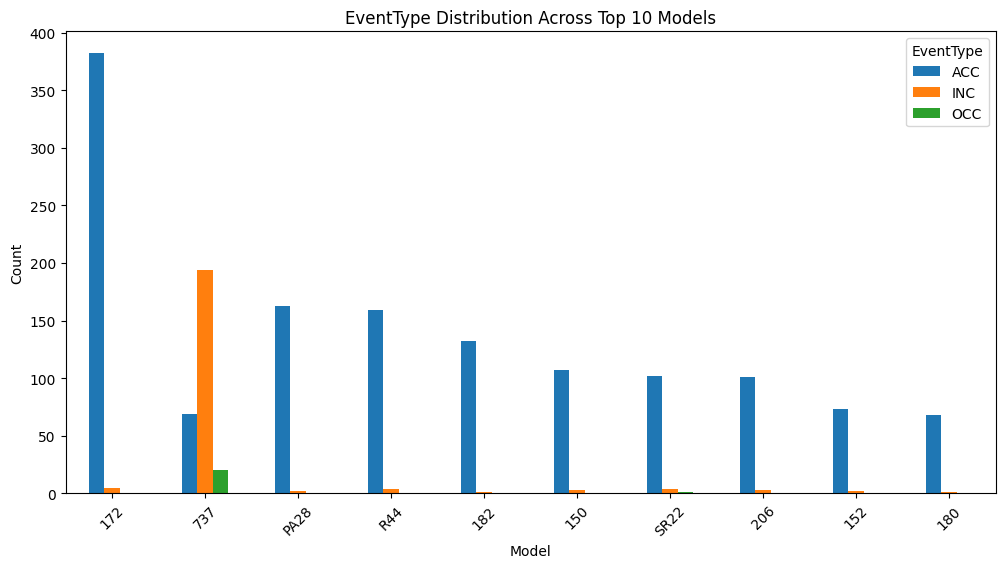

In [61]:
# Create contingency table and filter top 10 models
contingency_table_model = df.pivot_table(
    index='Model', 
    columns='EventType', 
    aggfunc='size', 
    fill_value=0
)

# Get the top 10 models based on total counts
filtered_model_table = contingency_table_model.loc[
    contingency_table_model.sum(axis=1).nlargest(10).index
]

# Grouped Bar Chart: EventType vs Top 10 Models
plt.figure(figsize=(12, 6))
top_models = contingency_table_model.sum(axis=1).nlargest(10).index  # Top 10 models
filtered_model_table = contingency_table_model.loc[top_models]

filtered_model_table.plot(kind='bar', figsize=(12, 6), title='EventType Distribution Across Top 10 Models')
plt.ylabel("Count")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.legend(title='EventType')
plt.show()

Based on this chart the most model that have ACC is 172 model, manufactured by Cessna. Boeing 737 model actually have the most INC, an incident that occured by small problem and usually handled before flying.

### Safety Rec

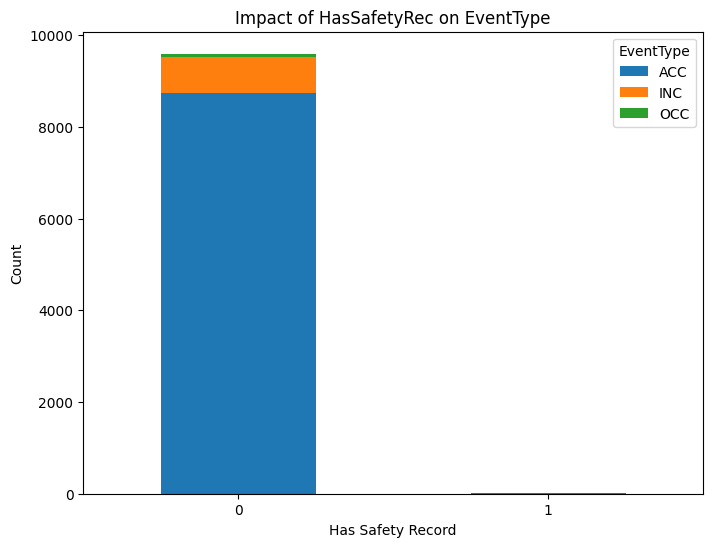

In [62]:
# Create contingency table and visualize: HasSafetyRec vs EventType
safety_rec_counts = pd.crosstab(df['HasSafetyRec'], df['EventType'])

# Stacked bar chart for HasSafetyRec vs EventType
safety_rec_counts.plot(kind='bar', stacked=True, figsize=(8, 6), title='Impact of HasSafetyRec on EventType', legend=True)
plt.ylabel("Count")
plt.xlabel("Has Safety Record")
plt.xticks(rotation=0)
plt.legend(title='EventType')
plt.show()


Based on this chart, our data shown that many of the ACC have no SafetyRec this could indicates the importance of such recomendation.

### Weather Condition

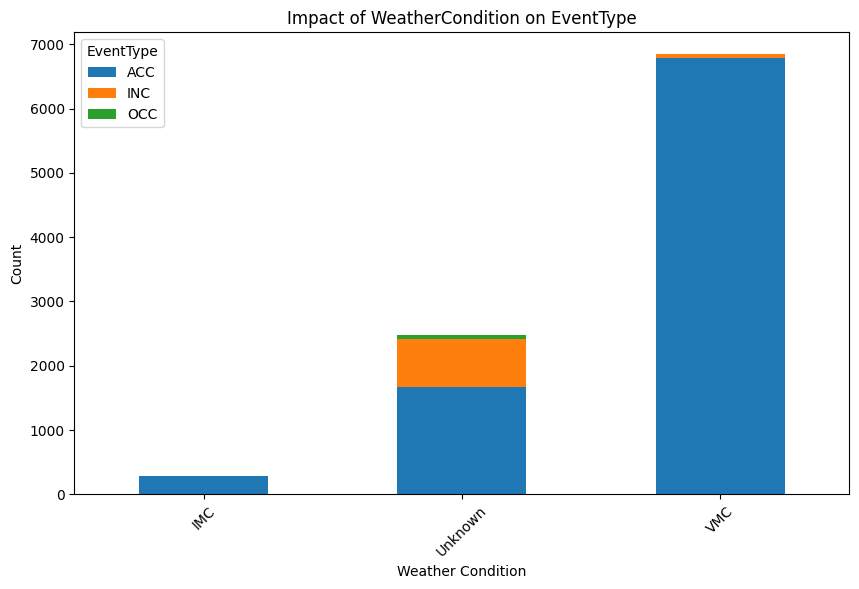

In [63]:
# Create contingency table and visualize: WeatherCondition vs EventType
weather_condition_counts = pd.crosstab(df['WeatherCondition'], df['EventType'])

# Stacked bar chart for WeatherCondition vs EventType
weather_condition_counts.plot(kind='bar', stacked=True, figsize=(10, 6), title='Impact of WeatherCondition on EventType', legend=True)
plt.ylabel("Count")
plt.xlabel("Weather Condition")
plt.xticks(rotation=45)
plt.legend(title='EventType')
plt.show()

Logically speaking, the more the pilot able to see outside their airplane the better their judgement. Although most of our data have VMC (Visual Meteorological Condition), it is also the highest in ACC. This could means that even though the pilot able to see doesn't necessarily able to react accordingly.

### Impact of FAR

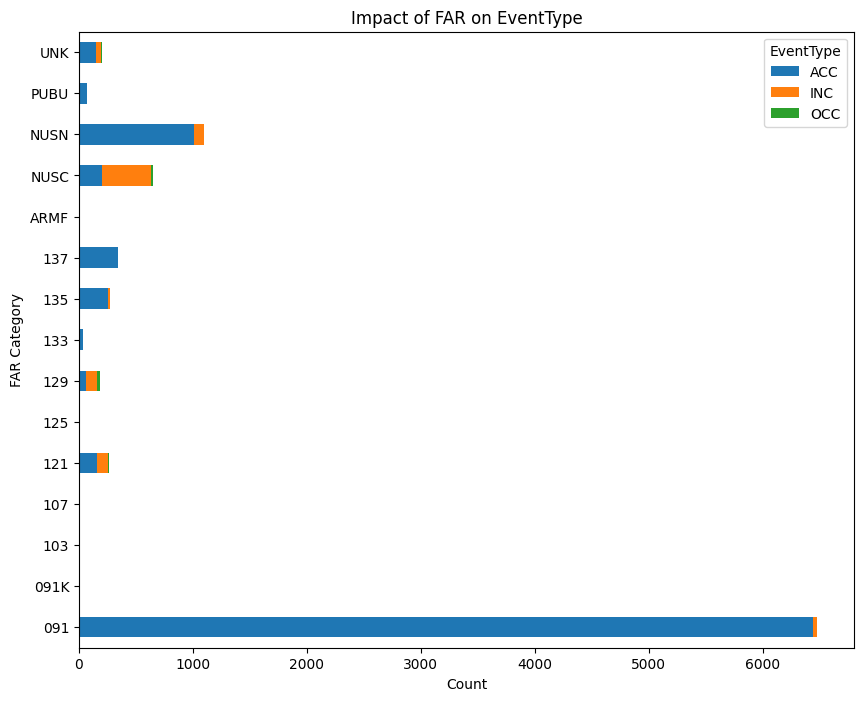

In [64]:
# Create contingency table and visualize: FAR vs EventType
far_counts = pd.crosstab(df['FAR'], df['EventType'])

# Horizontal bar chart for FAR vs EventType
far_counts.plot(kind='barh', stacked=True, figsize=(10, 8), title='Impact of FAR on EventType', legend=True)
plt.xlabel("Count")
plt.ylabel("FAR Category")
plt.legend(title='EventType', loc='upper right')
plt.show()

Based on this chart, the FAR (Federal Aviation Regulations) mostly are 091 which is general airplane regulations. This probably because the 091 is the most common regulation used for airplane, small and big alike.

### State that have the most Event

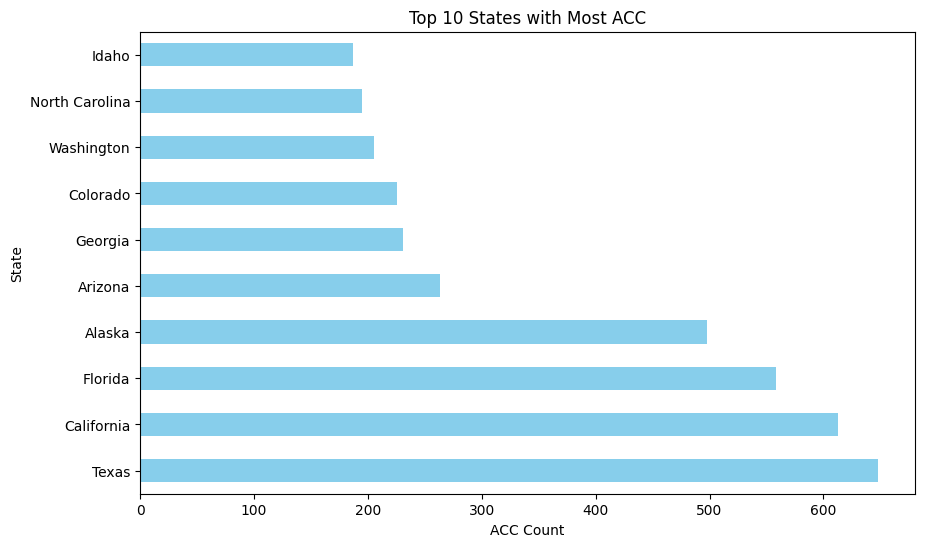

In [65]:
# Create contingency table and visualize: States with Most ACC
state_event_counts = df.groupby(['State', 'EventType']).size().unstack(fill_value=0)

# Top 10 states with the most ACC
top_states_acc = state_event_counts['ACC'].nlargest(10)

# Horizontal bar chart for top 10 states with most ACC
top_states_acc.plot(kind='barh', figsize=(10, 6), title='Top 10 States with Most ACC', color='skyblue')
plt.xlabel("ACC Count")
plt.ylabel("State")
plt.show()

Based on this chart, the highest states that have ACC event is Texas. This indicates that in Texas have approximately 130 ACC in a year. Followed by California, Florida, and Alaska. We may need to focus on this states in the future.

### EDA Conclusion

Based on the EDA we conducted, certain models are strongly associated with specific EventType. Evidently the barchart shows that ACC dominate across models, this suggests that model type can be a significant cause.

As for Safety Recommendations, this also correlates with the occurence of incidents and accidents potentially due to prior risk identification. This proven by how high the EventType of accident and how most of them have no Safety Recommendations.

As for Weather condition, it proven that Visibility actually doesn't mean that an accident will occured. This features may need to be supported by other features that can detail not only the visibility but the actual condition. But as for now, this still a valuable features.

For FAR (Federal Aviation Regulation) indicates that regulatory environment also plays a role in the number of accidents, making FAR is an important thing.

Lastly, geographic distribution could indicate regional risk factors or differences in operational environments.

# 5. Features Engineering

Before we delved further in Features Engineering, we will Split the data first.

## Data Split

In [66]:
X = df.drop(columns=['EventType'])
y = df['EventType']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (7690, 11)
Testing set size: (1923, 11)


## Handle Cardinality

In [67]:
X_train['City'].nunique()

4356

In [68]:
X_train['Country'].nunique()

142

In [69]:
X_train['State'].nunique()

197

Based on this the cardinality of City is very high, even though it is correlated it may result on our model be biased and have bad prediction behaviour. Also since the City can be represented by state and country, I decide to drop the column of City.

## Features Correlation

### Check correlation between categorical and categorical

In [70]:
# get the categorical features
categorical_features = ['City', 'State', 'Country', 'Make', 'Model', 'WeatherCondition', 'FAR']

p_values = []
results = []

for feature in categorical_features:
    # Create a contingency table (cross-tabulation between target and feature)
    contingency_table = pd.crosstab(X_train[feature], y_train)
    
    # Perform chi-squared test
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    
    p_values.append(p_value)
    
    # Interpret the result based on p-value
    if p_value < 0.05:
        results.append(f'{feature} is correlated with EventType')
    else:
        results.append(f'{feature} is not correlated with EventType')

# Display results
correlation_results = pd.DataFrame({
    'Feature': categorical_features,
    'P-Value': p_values,
    'Interpretation': results
})

correlation_results

,Feature,P-Value,Interpretation
0,City,4.468844e-41,City is correlated with EventType
1,State,0.000000e+00,State is correlated with EventType
2,Country,0.000000e+00,Country is correlated with EventType
3,Make,2.207489e-202,Make is correlated with EventType
4,Model,2.509654e-122,Model is correlated with EventType
5,WeatherCondition,0.000000e+00,WeatherCondition is correlated with EventType
6,FAR,0.000000e+00,FAR is correlated with EventType


### Check correlation between numerical and categorical

In [71]:
# get the numerical features
numerical_features = ['Latitude', 'Longitude', 'NumberOfEngines']
p_values = []
results = []

for feature in numerical_features:
    # Group the data by the unique values in y_train (EventType)
    groups = [X_train[y_train == category][feature] for category in y_train.unique()]
    
    # Perform ANOVA
    f_stat, p_value = f_oneway(*groups)
    p_values.append(p_value)
    
    # Interpret the result based on p-value
    if p_value < 0.05:
        results.append(f'{feature} is correlated with EventType')
    else:
        results.append(f'{feature} is not correlated with EventType')

# Display results
anova_results = pd.DataFrame({
    'Feature': numerical_features,
    'P-Value': p_values,
    'Interpretation': results
})

anova_results


,Feature,P-Value,Interpretation
0,Latitude,0.872726,Latitude is not correlated with EventType
1,Longitude,0.165236,Longitude is not correlated with EventType
2,NumberOfEngines,0.000000,NumberOfEngines is correlated with EventType


### Features selection

Based on these result, the features we will be using are State, Country, Make, Model, WeatherCondition, FAR, and NumberOfEngines. Even though I had high hopes for Latitude and Longitude, unfortunately it is not correlated. As for city since it have very high cardinality and it is 50% of the data, it could means that many of the city are only occured once or twice, therefore the column city will also be dropped.

Although State, Country, Make, and Model also have high cardinality, logically speaking the make and model are tightly correlated and could impact the EventType. Therefore we will select them as our features.

# 6. Model Definition

There are several model that we can use, which is KNN, SVM, Decision Tree, Random Forest, and XGBoost. Since I'm not sure which model is the best for this we will try each of them and find the best model and fine-tune it further.

In [72]:
# get each encoder and scaler and put it inside variable
onehot_encoder = OneHotEncoder(sparse_output=False,handle_unknown='ignore')
scaler = StandardScaler()
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=6000)

For our encoder, for features that have high cardinality we will using ordinal, the ordinal are not set since we don't want ordinality to our value just want them to label them using number. We don't use label encoder since the label encoder isn't suited to be used in a pipeline.

As for the low cardinality features, we will use One hot since it is the best encoder to handle the low cardinality features.

as for scaler, we will use standard scaler since the NumberOfEngine is lowly skewed.

In [73]:
X_train['NumberOfEngines'].skew()

1.4547891777474202

# 7. Model Training

## Preprocessing Settings

Get cardinal and numerical columns, for cardinal I will separate it as high cardinal and low cardinal. The column we drop will not be included, and will be dropped in preprocessing.

In [74]:
# get categorical and numerical, the categorical will be split to high and low cardinality
high_card_cols = ['State', 'Country', 'Make', 'Model']
low_card_cols = ['WeatherCondition', 'FAR']
num_cols = ['NumberOfEngines']

First we encode the target.

In [75]:
# encode the target using ordinal encoder
category_order = ['ACC', 'INC', 'OCC']
target_encoder = OrdinalEncoder(categories=[category_order])

In [76]:
# conver y_train to numpy, reshape it to 2D array, fit_transform it, then change the output to 1D array again
y_train_encoded = target_encoder.fit_transform(np.array(y_train).reshape(-1, 1)).ravel()

In [77]:
# conver y_test to numpy, reshape it to 2D array, transform it, then change the output to 1D array again
y_test_encoded = target_encoder.transform(np.array(y_test).reshape(-1, 1)).ravel()

Then we create the preprocessing process to be put inside a pipeline.

In [78]:
# create a preprocessing pipeline, using column transformer
preprocessing = ColumnTransformer(
    transformers=[
        # label the high cardinality features using ordinal encoder
        ('label', ordinal_encoder, high_card_cols),
        # encode the low cardinality features using onehot encoder
        ('onehot', onehot_encoder, low_card_cols),
        # scale the numerical column using standard scaler
        ('num', scaler, num_cols)
    ],
    # as for the features we are not selected, we will drop it
    remainder='drop'
)

In [79]:
# checking the preprocessing if it's working
X_train_preprocess = preprocessing.fit_transform(X_train)
X_test_preprocess = preprocessing.transform(X_test)

In [117]:
# Extract feature names from the ColumnTransformer
feature_names = preprocessing.get_feature_names_out()

# Create a DataFrame for X_train_preprocess with proper column names
Train_preprocess = pd.DataFrame(X_train_preprocess, columns=feature_names)

# Display the first few rows of the DataFrame
Train_preprocess.head()


,label__State,label__Country,label__Make,label__Model,onehot__WeatherCondition_IMC,onehot__WeatherCondition_Unknown,onehot__WeatherCondition_VMC,onehot__FAR_091,onehot__FAR_091K,onehot__FAR_103,...,onehot__FAR_129,onehot__FAR_133,onehot__FAR_135,onehot__FAR_137,onehot__FAR_ARMF,onehot__FAR_NUSC,onehot__FAR_NUSN,onehot__FAR_PUBU,onehot__FAR_UNK,num__NumberOfEngines
0,193.0,133.0,434.0,1767.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.504376
1,191.0,133.0,281.0,87.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.504376
2,172.0,133.0,232.0,326.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.504376
3,118.0,133.0,1190.0,1775.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.504376
4,2.0,133.0,1155.0,8.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.504376


## Creating Pipeline for Possible Model

### K-Nearest Neighbors (KNN)

In [81]:
# creating pipeline with preprocessing and KNN classifier
pipeline_KNN = Pipeline(steps=[
    ('preprocessor', preprocessing),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

In [82]:
# fit the pipeline with X_train and y_train
pipeline_KNN.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('label',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=6000),
                                                  ['State', 'Country', 'Make',
                                                   'Model']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['WeatherCondition', 'FAR']),
                                                 ('num', StandardScaler(),
                                                  ['NumberOfEngines'])])),
                ('classifier', KNeighborsClassifier())])

In [83]:
# predict the X_train
pipeline_KNN.predict(X_train)

array([0., 0., 0., ..., 0., 0., 0.])

In [84]:
# predict the X_test
y_pred_KNN = pipeline_KNN.predict(X_test)
y_pred_KNN

array([0., 0., 0., ..., 0., 0., 0.])

### Support Vector Machine (SVM)

In [85]:
# creating pipeline with preprocessing and SVM classifier
pipeline_SVC = Pipeline(steps=[
    ('preprocessor', preprocessing),
    ('classifier', SVC(kernel='rbf', random_state=26))
])

In [86]:
# fit the pipeline
pipeline_SVC.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('label',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=6000),
                                                  ['State', 'Country', 'Make',
                                                   'Model']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['WeatherCondition', 'FAR']),
                                                 ('num', StandardScaler(),
                                                  ['NumberOfEngines'])])),
                ('classifier', SVC(random_state=26))])

In [87]:
# predict X_train
pipeline_SVC.predict(X_train)

array([0., 0., 0., ..., 0., 0., 0.])

In [88]:
# predict X_test
y_pred_SVC = pipeline_SVC.predict(X_test)
y_pred_SVC

array([0., 0., 0., ..., 0., 0., 0.])

### Decision Tree

In [89]:
# creating pipeline with preprocessing and Decision Tree classifier
pipeline_DecTree = Pipeline(steps=[
    ('preprocessor', preprocessing),
    ('classifier', DecisionTreeClassifier(random_state=26))
])

In [90]:
# fit the pipeline
pipeline_DecTree.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('label',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=6000),
                                                  ['State', 'Country', 'Make',
                                                   'Model']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['WeatherCondition', 'FAR']),
                                                 ('num', StandardScaler(),
                                                  ['NumberOfEngines'])])),
                ('classifier', DecisionTreeClassifier(random_state=26))])

In [91]:
# predict X_train
pipeline_DecTree.predict(X_train)

array([0., 0., 0., ..., 0., 0., 0.])

In [92]:
# predict X_test
y_pred_DecTree = pipeline_DecTree.predict(X_test)
y_pred_DecTree

array([0., 0., 0., ..., 0., 0., 0.])

### Random Forest

In [93]:
# creating pipeline with preprocessing and Random Forest classifier
pipeline_RandFor = Pipeline(steps=[
    ('preprocessor', preprocessing),
    ('classifier', RandomForestClassifier(random_state=26))
])

In [94]:
# fit the pipeline
pipeline_RandFor.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('label',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=6000),
                                                  ['State', 'Country', 'Make',
                                                   'Model']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['WeatherCondition', 'FAR']),
                                                 ('num', StandardScaler(),
                                                  ['NumberOfEngines'])])),
                ('classifier', RandomForestClassifier(random_state=26))])

In [95]:
# predict the X_test
y_pred_DecTree = pipeline_RandFor.predict(X_test)
y_pred_DecTree

array([0., 0., 0., ..., 0., 0., 0.])

### XGBoost

In [119]:
# creating pipeline with preprocessing and XGBoost classifier
pipeline_XGB = Pipeline(steps=[
    ('preprocessor', preprocessing),
    ('classifier', XGBClassifier(eval_metric='mlogloss', random_state=26))
])

In [97]:
# fit the pipeline
pipeline_XGB.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('label',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=6000),
                                                  ['State', 'Country', 'Make',
                                                   'Model']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['WeatherCondition', 'FAR']),
                                                 ('num', StandardScaler(),
                                                  ['NumberOfEngines'])])),
                ('classifier',
                 XGBClassifie...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [98]:
# predict X_test
y_pred_XGB = pipeline_XGB.predict(X_test)
y_pred_XGB

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

# 8. Model Evaluation

Now since we already create our possible model, we will crossvalidate them and choose the best one. Since in classification prediction we should focus on either reduce False Positive or False Negative we will use either recall or precision. In our case, since we want to effectively predict ACC to prevent an airplane to fly and cause an accident we wan't to reduce False Negative where an airplane is predicted not ACC but instead it is an ACC. Therefore we will use recall for our evaluation.

## Evaluation Recall

#### Evaluation KNN

In [99]:
# Predict on Training Set
y_pred_train_knn = pipeline_KNN.predict(X_train)
# Predict on Test Set
y_pred_test_knn = pipeline_KNN.predict(X_test)

# Evaluate Recall
print('KNN Recall - Train Set  : ', recall_score(y_train_encoded, y_pred_train_knn, average='macro'))
print('KNN Recall - Test Set   : ', recall_score(y_test_encoded, y_pred_test_knn, average='macro'))
print('')

KNN Recall - Train Set  :  0.5922089574263002
KNN Recall - Test Set   :  0.4845756015948905



#### Evaluation SVM

In [100]:
# Predict on Training Set
y_pred_train_svm = pipeline_SVC.predict(X_train)
# Predict on Test Set
y_pred_test_svm = pipeline_SVC.predict(X_test)

# Evaluate Recall
print('SVM Recall - Train Set  : ', recall_score(y_train_encoded, y_pred_train_svm, average='macro'))
print('SVM Recall - Test Set   : ', recall_score(y_test_encoded, y_pred_test_svm, average='macro'))
print('')

SVM Recall - Train Set  :  0.3333333333333333
SVM Recall - Test Set   :  0.3333333333333333



#### Evaluation Decision Tree

In [101]:
# Predict on Training Set
y_pred_train_dt = pipeline_DecTree.predict(X_train)
# Predict on Test Set
y_pred_test_dt = pipeline_DecTree.predict(X_test)

# Evaluate Recall
print('Decision Tree Recall - Train Set  : ', recall_score(y_train_encoded, y_pred_train_dt, average='macro'))
print('Decision Tree Recall - Test Set   : ', recall_score(y_test_encoded, y_pred_test_dt, average='macro'))
print('')

Decision Tree Recall - Train Set  :  0.9402419477115688
Decision Tree Recall - Test Set   :  0.5552985796542426



#### Evaluation Random Forest

In [102]:
# Predict on Training Set
y_pred_train_dt = pipeline_RandFor.predict(X_train)
# Predict on Test Set
y_pred_test_dt = pipeline_RandFor.predict(X_test)

# Evaluate Recall
print('Random Forest Recall - Train Set  : ', recall_score(y_train_encoded, y_pred_train_dt, average='macro'))
print('Random Forest Recall - Test Set   : ', recall_score(y_test_encoded, y_pred_test_dt, average='macro'))
print('')

Random Forest Recall - Train Set  :  0.9569996561396669
Random Forest Recall - Test Set   :  0.5598414530216475



#### Evaluation XGBoost

In [103]:
# Predict on Training Set
y_pred_train_dt = pipeline_XGB.predict(X_train)
# Predict on Test Set
y_pred_test_dt = pipeline_XGB.predict(X_test)

# Evaluate Recall
print('XGBoost Recall - Train Set  : ', recall_score(y_train_encoded, y_pred_train_dt, average='macro'))
print('XGBoost Recall - Test Set   : ', recall_score(y_test_encoded, y_pred_test_dt, average='macro'))
print('')

XGBoost Recall - Train Set  :  0.9152294590833279
XGBoost Recall - Test Set   :  0.565278246632316



### Recall Scores for Train and Test Sets

| Model           | Recall - Train Set | Recall - Test Set |
|------------------|--------------------|-------------------|
| KNN             | 0.5922             | 0.4846            |
| SVM             | 0.3333             | 0.3333            |
| Decision Tree   | 0.9402             | 0.5553            |
| Random Forest   | 0.9570             | 0.5598            |
| XGBoost         | 0.9152             | 0.5653            |

Based on this recall result, many of our models are overfit apart from KNN and SVM which have a pretty close score even though its nowhere near good. But this maybe due to how these recall only validate one split. To make sure if my models are good, we need to do a cross validation that will do a more robust validation.

## Cross Validation

In [104]:
# Define a custom scorer for macro recall (for multiclass problems)
custom_recall_scorer = make_scorer(recall_score, average='macro')

#### Cross Validation for KNN

In [105]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(
    estimator=pipeline_KNN,    # Your pipeline
    X=X_train,                # Features
    y=y_train_encoded,        # Encoded target
    cv=5,                     # Number of folds
    scoring=custom_recall_scorer  # Use macro recall as the scoring metric
)

# Print cross-validation results
print('Recall Score - All - Cross Validation  : ', cv_scores)
print('Recall Score - Mean - Cross Validation : ', cv_scores.mean())
print('Recall Score - Std - Cross Validation  : ', cv_scores.std())
print('Recall Score - Range of Test-Set       : ',
      (cv_scores.mean() - cv_scores.std()), '-', (cv_scores.mean() + cv_scores.std()))


Recall Score - All - Cross Validation  :  [0.55679381 0.52908886 0.50895357 0.50588962 0.54329036]
Recall Score - Mean - Cross Validation :  0.5288032442004029
Recall Score - Std - Cross Validation  :  0.019557472583533714
Recall Score - Range of Test-Set       :  0.5092457716168692 - 0.5483607167839366


#### Cross Validation for SVM

In [106]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(
    estimator=pipeline_SVC,    # Your pipeline
    X=X_train,                # Features
    y=y_train_encoded,        # Encoded target
    cv=5,                     # Number of folds
    scoring=custom_recall_scorer  # Use macro recall as the scoring metric
)

# Print cross-validation results
print('Recall Score - All - Cross Validation  : ', cv_scores)
print('Recall Score - Mean - Cross Validation : ', cv_scores.mean())
print('Recall Score - Std - Cross Validation  : ', cv_scores.std())
print('Recall Score - Range of Test-Set       : ',
      (cv_scores.mean() - cv_scores.std()), '-', (cv_scores.mean() + cv_scores.std()))


Recall Score - All - Cross Validation  :  [0.33333333 0.33333333 0.33333333 0.33333333 0.33333333]
Recall Score - Mean - Cross Validation :  0.3333333333333333
Recall Score - Std - Cross Validation  :  0.0
Recall Score - Range of Test-Set       :  0.3333333333333333 - 0.3333333333333333


#### Cross Validation for Decision Tree

In [107]:
cv_scores = cross_val_score(
    estimator=pipeline_DecTree,  # Your Decision Tree pipeline
    X=X_train,                  # Training features
    y=y_train_encoded,          # Encoded training target
    cv=5,                       # Number of folds
    scoring=custom_recall_scorer  # Macro recall metric
)

# Print cross-validation results
print('Recall Score - All - Cross Validation  : ', cv_scores)
print('Recall Score - Mean - Cross Validation : ', cv_scores.mean())
print('Recall Score - Std - Cross Validation  : ', cv_scores.std())
print('Recall Score - Range of Test-Set       : ',
      (cv_scores.mean() - cv_scores.std()), '-', (cv_scores.mean() + cv_scores.std()))

Recall Score - All - Cross Validation  :  [0.62990458 0.62684063 0.5697583  0.59936938 0.52456181]
Recall Score - Mean - Cross Validation :  0.5900869398054888
Recall Score - Std - Cross Validation  :  0.03931726789942444
Recall Score - Range of Test-Set       :  0.5507696719060643 - 0.6294042077049132


#### Cross Validation for Random Forest

In [108]:
cv_scores = cross_val_score(
    estimator=pipeline_RandFor,  # Your Decision Tree pipeline
    X=X_train,                  # Training features
    y=y_train_encoded,          # Encoded training target
    cv=5,                       # Number of folds
    scoring=custom_recall_scorer  # Macro recall metric
)

# Print cross-validation results
print('Recall Score - All - Cross Validation  : ', cv_scores)
print('Recall Score - Mean - Cross Validation : ', cv_scores.mean())
print('Recall Score - Std - Cross Validation  : ', cv_scores.std())
print('Recall Score - Range of Test-Set       : ',
      (cv_scores.mean() - cv_scores.std()), '-', (cv_scores.mean() + cv_scores.std()))

Recall Score - All - Cross Validation  :  [0.60271575 0.57927216 0.5508585  0.62709565 0.5477778 ]
Recall Score - Mean - Cross Validation :  0.5815439735092165
Recall Score - Std - Cross Validation  :  0.03036482635884735
Recall Score - Range of Test-Set       :  0.5511791471503692 - 0.6119087998680638


#### Cross Validation for XGBoost

In [109]:
cv_scores = cross_val_score(
    estimator=pipeline_XGB,  # Your Decision Tree pipeline
    X=X_train,                  # Training features
    y=y_train_encoded,          # Encoded training target
    cv=5,                       # Number of folds
    scoring=custom_recall_scorer  # Macro recall metric
)

# Print cross-validation results
print('Recall Score - All - Cross Validation  : ', cv_scores)
print('Recall Score - Mean - Cross Validation : ', cv_scores.mean())
print('Recall Score - Std - Cross Validation  : ', cv_scores.std())
print('Recall Score - Range of Test-Set       : ',
      (cv_scores.mean() - cv_scores.std()), '-', (cv_scores.mean() + cv_scores.std()))

Recall Score - All - Cross Validation  :  [0.59182255 0.59655436 0.55985167 0.64461612 0.5492074 ]
Recall Score - Mean - Cross Validation :  0.5884104176143133
Recall Score - Std - Cross Validation  :  0.03343508968392245
Recall Score - Range of Test-Set       :  0.5549753279303908 - 0.6218455072982358


### Model Comparison

| Model           | Mean Recall | Std Recall | Performance Range            |
|------------------|-------------|------------|-------------------------------|
| KNN             | 0.5288      | 0.0196     | 0.5092 - 0.5484              |
| SVM             | 0.3333      | 0.0000     | 0.3333 - 0.3333              |
| Decision Tree   | 0.5901      | 0.0393     | 0.5508 - 0.6294              |
| Random Forest   | 0.5815      | 0.0304     | 0.5512 - 0.6119              |
| XGBoost         | 0.5884      | 0.0334     | 0.5550 - 0.6218              |

Based on these cross validation, the Decision tree have the highest Mean Recall which indicates that the model correctly predict the result, followed tightly with Random Forest and XGBoost. While in Std Recall, the Random Forest are the lowest which indicates that in terms of consistency the Random Forest are the best model. As for our case, since we want to correctly predict True Positive and avoid False Negative, we will focus on Mean Recall. In conclusion, the best model for our problems is Decision Tree.

We then will Hyper parameter tuning it further to achieve even greater model.

## Hyperparameter Tuning

For our hyperparameter Tuning, we will use GridSearch. This tuner evaluates the model for each hyperparameter combination and identifies the configuration that maximize a given scoring metric. This tuner also use cross validation to evaluate its hyperparameter, making it more robust and unbiassed toward a specific train-test split.

In [134]:
parameters = {
    # split criteria
    'classifier__criterion': ['gini'],
    # Max tree depth
    'classifier__max_depth': [15, 20, 25],
    # minimum sample required to split
    'classifier__min_samples_split': [2, 5, 10],
    # minimum sample per leaf
    'classifier__min_samples_leaf': [1, 2, 4]
}

# using gridsearch
grid_search = GridSearchCV(
    # call the pipeline
    estimator=pipeline_DecTree,
    # call the input parameters
    param_grid=parameters,
    # 20 fold cross-validation
    cv=20,
    # use all resource
    n_jobs=-1,
    # using recall scorer
    scoring=custom_recall_scorer,
    # how detailed the output will be
    verbose=2
)

grid_search.fit(X_train, y_train_encoded)

Fitting 20 folds for each of 27 candidates, totalling 540 fits


GridSearchCV(cv=20,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('label',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=6000),
                                                                         ['State',
                                                                          'Country',
                                                                          'Make',
                                                                          'Model']),
                                                                        ('onehot',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['WeatherCondition',
                                                                          'FAR']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['NumberOfEngines'])])),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=26))]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['gini'],
                         'classifier__max_depth': [15, 20, 25],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10]},
             scoring=make_scorer(recall_score, average=macro), verbose=2)

In [135]:
# check the parameter and check the recall score
print("Best Parameters:", grid_search.best_params_)
print("Best Recall:", grid_search.best_score_)

Best Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 15, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10}
Best Recall: 0.5893801450857324


In [138]:
# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate performance
print(classification_report(y_test_encoded, y_pred, target_names=['ACC', 'INC', 'OCC']))


              precision    recall  f1-score   support

         ACC       0.96      0.98      0.97      1761
         INC       0.67      0.56      0.61       155
         OCC       0.25      0.14      0.18         7

    accuracy                           0.94      1923
   macro avg       0.63      0.56      0.59      1923
weighted avg       0.94      0.94      0.94      1923



In [139]:
# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_train)

# Evaluate performance
print(classification_report(y_train_encoded, y_pred, target_names=['ACC', 'INC', 'OCC']))


              precision    recall  f1-score   support

         ACC       0.98      0.99      0.99      6995
         INC       0.87      0.81      0.84       640
         OCC       0.77      0.49      0.60        55

    accuracy                           0.97      7690
   macro avg       0.87      0.76      0.81      7690
weighted avg       0.97      0.97      0.97      7690



### Recall and Overfitting/Underfitting Analysis

| Dataset      | Class | Recall | Observations                                                                 |
|--------------|-------|--------|------------------------------------------------------------------------------|
| **X_train**  | ACC   | 0.99   | Very high recall, indicating the model captures most ACC cases in training.  |
|              | INC   | 0.81   | Decent recall but lower than ACC, suggesting potential difficulty in INC.    |
|              | OCC   | 0.49   | Low recall for OCC, indicating underperformance for this rare class.        |
| **X_test**   | ACC   | 0.98   | Slightly lower than training, but consistent, showing good generalization.  |
|              | INC   | 0.56   | Significant drop compared to training, indicating possible overfitting.     |
|              | OCC   | 0.14   | Very low recall, suggesting underfitting for this rare class.               |

There are several Key that we can see, in terms of predicting ACC it is a Good fit with the different Recall score of 0.99 in train and 0.98 in test. Therefore in terms of ACC, the model is good fit.

Although the model is good fit in ACC, it show overfit and underfit in predicting INC and OCC. This is likely due to data disparity and could be handled with increasing the diversity of data using techniques such as SMOTE. Since we get overfit in predicting ACC, it is a good enough model for our purpose and we can do SMOTE for the future update.

# 9. Model Saving

Prepare the model to be saved.

In [140]:
# Export the model using pickle
with open('model.pkl','wb') as file:
    pickle.dump(best_model, file)

# 10. Model Inference

In [142]:
# get the new data
new_data = {
    'City': ['Example City', 'São Tomé', 'Derby'],
    'State': ['Example State', 'Unknown State', 'Unknown State'],
    'Country': ['United States', 'St Lucia', 'United Kingdom'],
    'HasSafetyRec': ['FALSE', 'False', 'False'],
    'Latitude': ['37.7749', '0.378471', '52.830684'],
    'Longitude': ['-122.4194', '6.712757', '-1.328283'],
    'Make': ['CESSNA', 'BOEING', 'BOEING'],
    'Model': ['172', '767', '767-300F'],
    'NumberOfEngines': [1, 1, 2],
    'WeatherCondition': ['VMC', 'Unknown', 'Unknown'],
    'FAR': ['091', 'NUSC', '121']
}

# put it inside dataframe
new_data_df = pd.DataFrame(new_data)
new_data_df

,City,State,Country,HasSafetyRec,Latitude,Longitude,Make,Model,NumberOfEngines,WeatherCondition,FAR
0,Example City,Example State,United States,FALSE,37.7749,-122.4194,CESSNA,172,1,VMC,091
1,São Tomé,Unknown State,St Lucia,False,0.378471,6.712757,BOEING,767,1,Unknown,NUSC
2,Derby,Unknown State,United Kingdom,False,52.830684,-1.328283,BOEING,767-300F,2,Unknown,121


In [143]:
# make a prediction with new_data_df
prediction = best_model.predict(new_data_df)

# for loop to predict each rows
for i in prediction:
    if i == 0:
        print('This Airplane have the possibility of Accident')
    elif i == 1:
        print('This Airplane have the possibility of Incident')
    elif i == 2:
        print('This Airplane have the possibility of Occurance')

This Airplane have the possibility of Accident
This Airplane have the possibility of Incident
This Airplane have the possibility of Incident


Note: There are also inference files outside this notebook.

# 11. Conclusion

Airplane accidents, while rare, have a devastating consequences, this is proven on how public will always see airplane accident as a tragic accident due to high casualties it will bring. Predictive modeling can play a pivotal role in enhancing aviation safety by identifying potential risks and enable preventive actions. Based on the analysis and modeling effort, we can draw some conclusion.

Certain airplane models are significantly associated with ACC, making model are one of the critical predictor for accidents. The lacks of safety recommendations also correlated with how high an accident happens, indicating that this Safety recommendation of prior risk identification are important to do a preventive measures. This also inline with Federal Aviation Regulation (FAR) influence accident occurences, indicating that this is also an essential factor in predicting risks.

Meanwhile, weather conditions does not guarantee accident prevention. However, it also remain a valuable predictive features, with further refinement needed to capture their full impact. Lastly, regional difference in operational indicate that location-based insights are vital for accident prediction.

**Model Conclusion**<br>
The Decision Tree model, hyperparameter tuned using GridSearch demonstrate strong performance in predicting ACC. This model generalized well for the majority class and aligns with the goal of identifying accidents effectively. As for minority classes, the model struggles with predicting INC and OCC, showing sings of overfitting and underfitting due to data disparity.

## Recommendation

The Decision Tree model is well-suited for the primary goal of identifying ACC. it can be deployed to enhance safety measures and minimize the risk of severe accidents.

As for future improvements:
 - we need to adress data imbalance with techniques like SMOTE to improve predictions for INC and OCC.
 -  Explore additional features or refine existing ones for more comprehensive risk assessment.
 - Consider other ensemble methods like Random Forest or XGBoost since they have a tight Recall score with Decision Tree.

**Final Words**<br>
The Decision Tree model serves as a strong foundation for predicting airplane accident risks, particularly for ACC. It aligns with the broader objective of preventing catastrophic consequences in the aviation industry. Data balancing and feature refinement will further bolster this model effectiveness.

### Conceptual Problems

Answer the following questions:

1. Explain the background of bagging and how bagging works!

2. Explain the difference between the working mechanism of the Random Forest algorithm and the boosting algorithm you chose!

3. Explain what is meant by Cross Validation!

##### 1. Explain the background of bagging and how bagging works!

Bagging was developed to address the following issues commonly encountered in machine learning models such as overfitting, high variance, and model stability. Bagging solve this problems by combining multiple models, trained on different subsets of the data, and improve overall predictive performance.

Bagging will generate multiple subsets of training data, it then train the same machine learning algorithm on each subset. Then it combine the predictions from all models.

##### 2. Explain the difference between the working mechanism of the Random Forest algorithm and the boosting algorithm you chose!

Random forest is a bagging algorithm, it working by making trees trained independently, it will reduces variance by average the vales, it is a faster computation resource, this model is best for handling high variance.

Meanwhile, the XGBoost is a boosting algorithm, it working by making trees trained sequentially, it reduces bias by focusing on errors, this model slower since it bult sequentially, the model are complex and requres fine-tuning to make it have the best result.

##### 3. Explain what is meant by Cross Validation!

Cross validation is a technique to evaluate a machine learning model's performance and score its ability to generalize to unseen data. It works by splitting the dataset into K-fold, where each fold is used as the validation set while the remaining K-1 folds are for training. This process repeated by K times and the evaluation metric is averaged across all folds. Cross validation is a critical tool in machine learning, for assessing model performance and to help it choose the most optimal hyperparameters.